<a href="https://colab.research.google.com/github/ybxfatfat/hello_world/blob/master/option_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

hs_300 = pd.read_csv('RESSET_IDXDRET_daily.csv')
hs_300

,指数名称_IdxNm,交易日期_TrdDt,收盘价_ClPr,涨跌幅_ChgPct,指数日收益率_IdxDRet,Unnamed: 5
0,沪深300,2013-01-04,2524.41,0.057750,0.0006,NaN
1,沪深300,2013-01-07,2535.99,0.458563,0.0046,NaN
2,沪深300,2013-01-08,2525.33,-0.420152,-0.0042,NaN
3,沪深300,2013-01-09,2526.13,0.031521,0.0003,NaN
4,沪深300,2013-01-10,2530.57,0.175882,0.0018,NaN
...,...,...,...,...,...,...
2667,沪深300,2023-12-25,3347.45,0.306323,0.0031,NaN
2668,沪深300,2023-12-26,3324.79,-0.676951,-0.0068,NaN
2669,沪深300,2023-12-27,3336.36,0.347902,0.0035,NaN
2670,沪深300,2023-12-28,3414.54,2.343367,0.0234,NaN


C:\Users\dell\AppData\Local\Temp/ipykernel_17288/2118125737.py:27: RuntimeWarning: invalid value encountered in double_scalars
  variance = (sigma ** 2) * (1 - np.exp(-2 * theta * dt)) / (2 * theta)


Estimated parameters: theta = 0.1, mu = 3836.1356198347103, sigma = 229.02297408447936


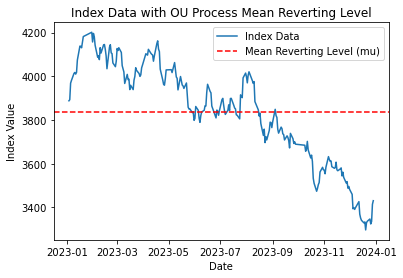

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
hs_300['Date'] = pd.to_datetime(hs_300['交易日期_TrdDt'])

# Load index data from CSV
period = hs_300[(hs_300['Date'] >= start_date) & (hs_300['Date'] <= end_date)]
index_data = period['收盘价_ClPr'].values

# Define the log-likelihood function for the OU process
def ou_log_likelihood(params, data, dt):
    theta, mu, sigma = params

    n = len(data)
    log_likelihood = 0

    for i in range(1, n):
        x_prev = data[i-1]
        x_curr = data[i]

        # Mean and variance of the conditional distribution
        mean = x_prev * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt))
        variance = (sigma ** 2) * (1 - np.exp(-2 * theta * dt)) / (2 * theta)

        # Log-likelihood contribution of the i-th observation
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - ((x_curr - mean) ** 2) / (2 * variance)

    return -log_likelihood  # Negative log-likelihood for minimization

# Time step (in days)
dt = 1/period.shape[0]  # Assuming daily data

# Initial parameter guesses
initial_guess = [0.1, np.mean(index_data), np.std(index_data)]

# Perform MLE
result = minimize(ou_log_likelihood, initial_guess, args=(index_data, dt), method='L-BFGS-B', bounds=[(0, None), (None, None), (0, None)])

theta_est, mu_est, sigma_est = result.x
print(f"Estimated parameters: theta = {theta_est}, mu = {mu_est}, sigma = {sigma_est}")

# Plot the original index data and the mean-reverting level
plt.plot(period['Date'], index_data, label='Index Data')
plt.axhline(y=mu_est, color='r', linestyle='--', label='Mean Reverting Level (mu)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Index Data with OU Process Mean Reverting Level')
plt.legend()
plt.show()


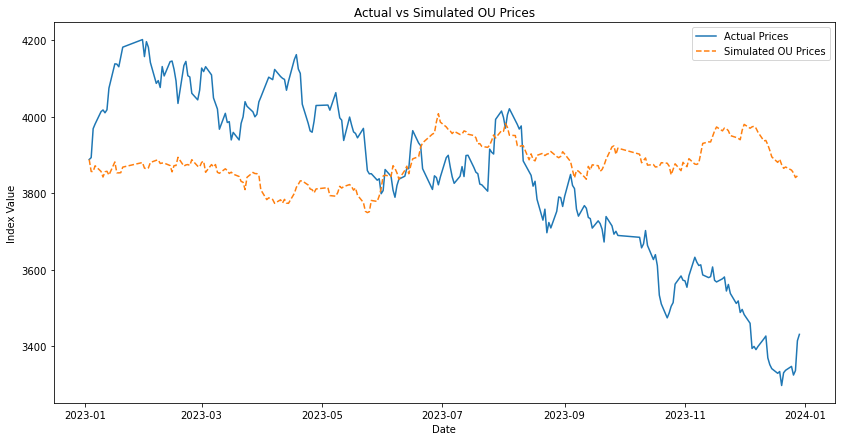

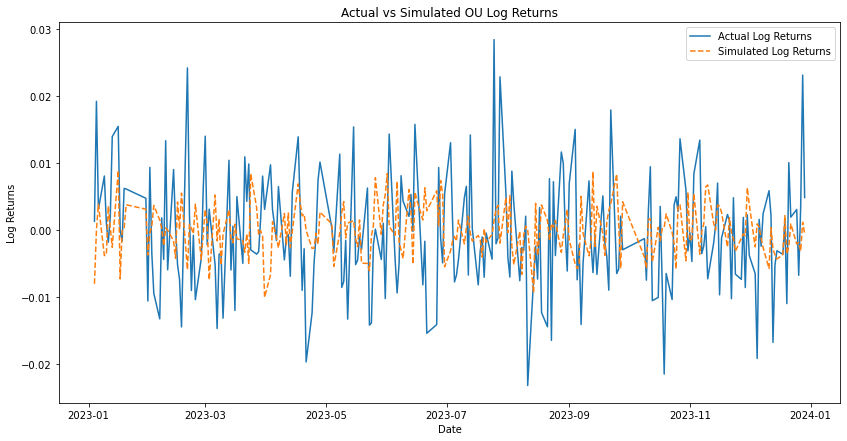

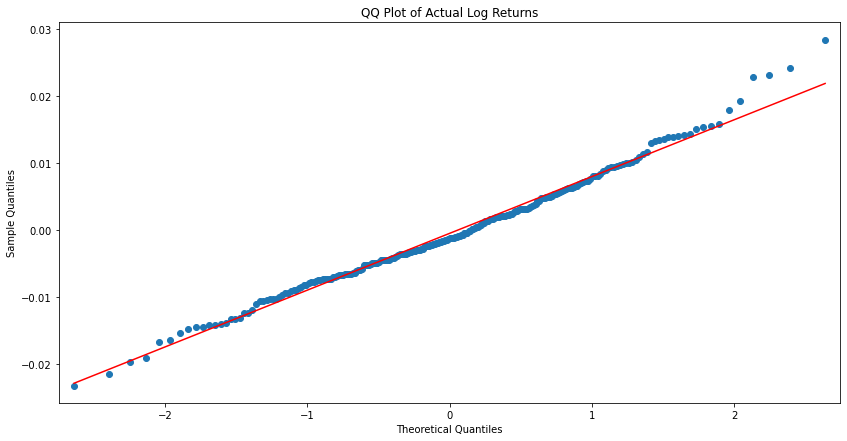

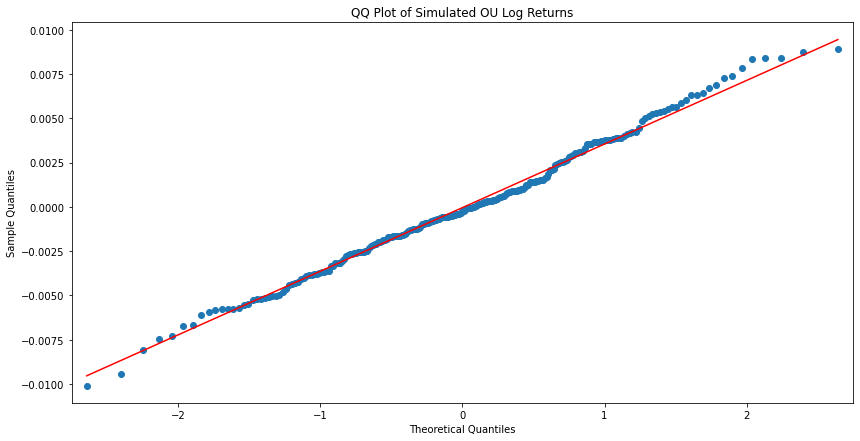

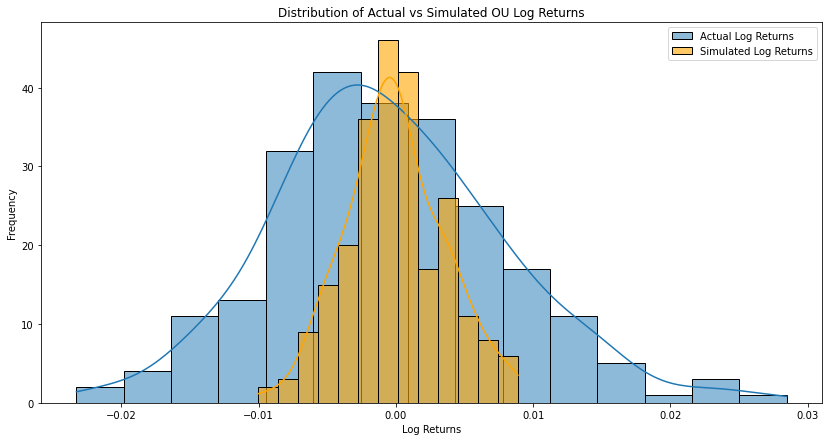

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

dates = period['Date']
# 计算对数收益率
log_returns = np.diff(np.log(index_data))

simulated_prices = [index_data[0]]
for i in range(1, len(index_data)):
    simulated_price = simulated_prices[-1] + theta_est*(mu_est-simulated_prices[-1]) * dt + sigma_est * np.sqrt(dt) * np.random.normal()
    simulated_prices.append(simulated_price)

# 绘制实际价格与仿真价格
plt.figure(figsize=(14, 7))
plt.plot(dates, index_data, label='Actual Prices')
plt.plot(dates, simulated_prices, label='Simulated OU Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Actual vs Simulated OU Prices')
plt.legend()
plt.show()

# 绘制实际对数收益率与仿真对数收益率的比较
simulated_log_returns = np.diff(np.log(simulated_prices))
plt.figure(figsize=(14, 7))
plt.plot(dates[1:], log_returns, label='Actual Log Returns')
plt.plot(dates[1:], simulated_log_returns, label='Simulated Log Returns', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Actual vs Simulated OU Log Returns')
plt.legend()
plt.show()

# 绘制对数收益率的QQ图
plt.figure(figsize=(14, 7))
qqplot(log_returns, line='s', ax=plt.gca())
plt.title('QQ Plot of Actual Log Returns')
plt.show()

plt.figure(figsize=(14, 7))
qqplot(simulated_log_returns, line='s', ax=plt.gca())
plt.title('QQ Plot of Simulated OU Log Returns')
plt.show()

# 绘制对数收益率的分布图
plt.figure(figsize=(14, 7))
sns.histplot(log_returns, kde=True, label='Actual Log Returns')
sns.histplot(simulated_log_returns, kde=True, color='orange', label='Simulated Log Returns', alpha=0.6)
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Simulated OU Log Returns')
plt.legend()
plt.show()

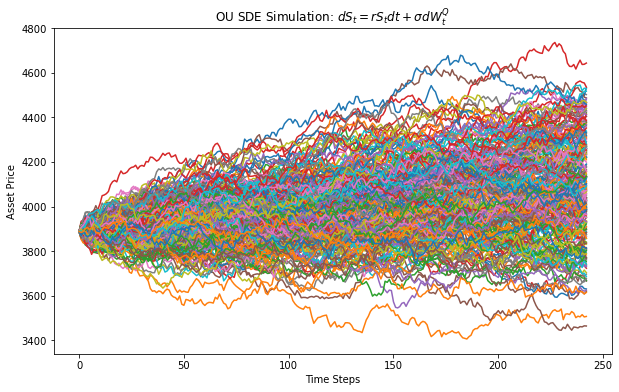

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ou(S0, r, sigma, T, dt, num_paths):
    """
    使用Euler-Maruyama方法模拟dS_t = r S_t dt + sigma dW_t的过程

    参数:
    S0 : float : 初始资产价格
    r : float : 无风险利率
    sigma : float : 波动率
    T : float : 模拟的总时间（以年为单位）
    dt : float : 时间步长
    num_paths : int : 模拟路径数

    返回:
    np.ndarray : 模拟的资产价格路径
    """
    num_steps = int(T / dt)
    paths = np.zeros((num_steps + 1, num_paths))
    paths[0] = S0

    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, np.sqrt(dt), num_paths)
        paths[t] = paths[t-1] + r * paths[t-1] * dt + sigma * dW

    final_prices = paths[-1]
    return paths, final_prices

# 参数设置
S0 = index_data[0]  # 初始资产价格
r = 0.05  # 无风险利率
sigma = sigma_est  # 波动率
T = 1.0  # 总时间（以年为单位）
num_paths = period.shape[0] # 模拟路径数

# 模拟资产价格路径
paths, final_prices = simulate_ou(S0, r, sigma, T, dt, num_paths)

# 绘制模拟路径
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(paths[:, i], lw=1.5)
plt.title('OU SDE Simulation: $dS_t = r S_t dt + \sigma dW^Q_t$')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

估计的参数: mu = -0.11680381187493279, sigma = 0.13208585973453296


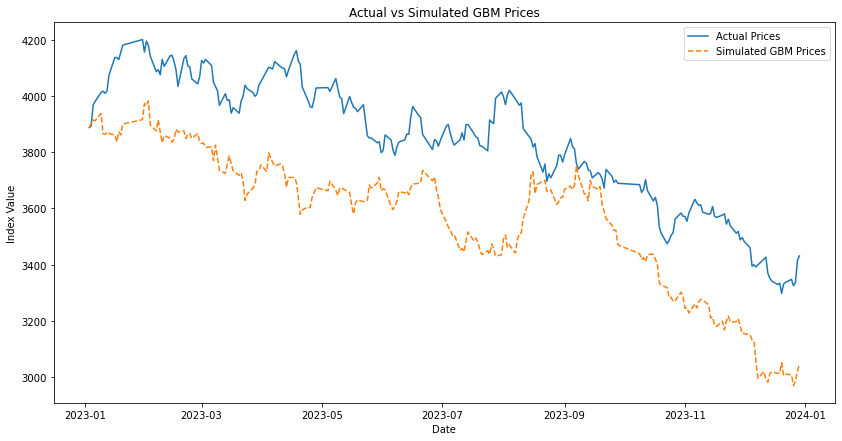

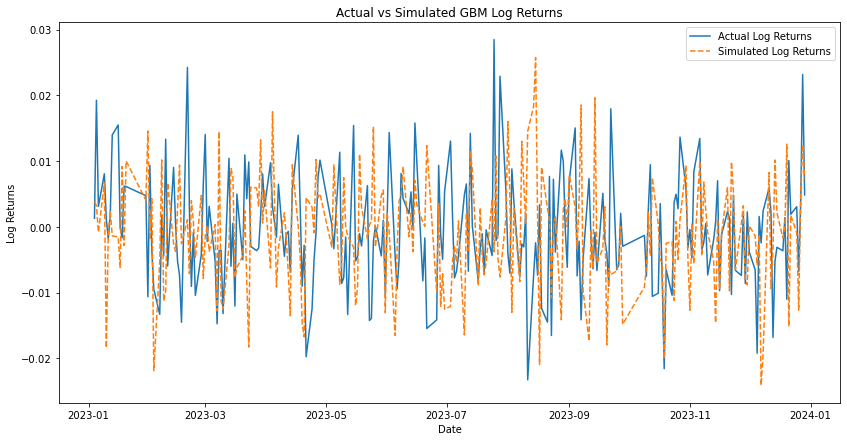

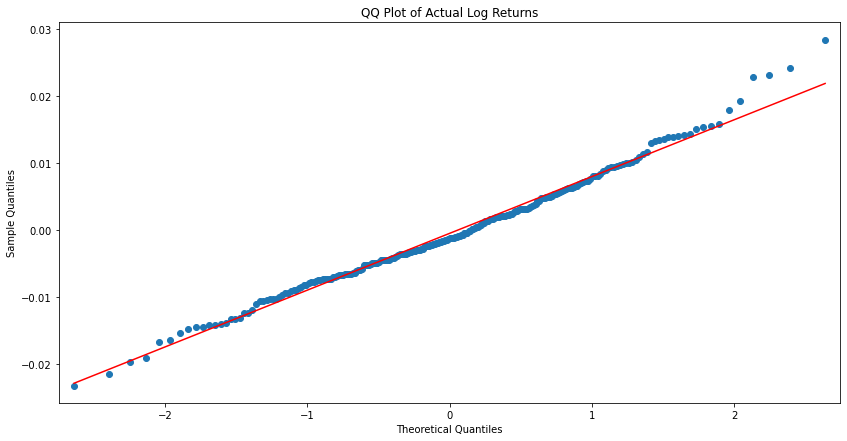

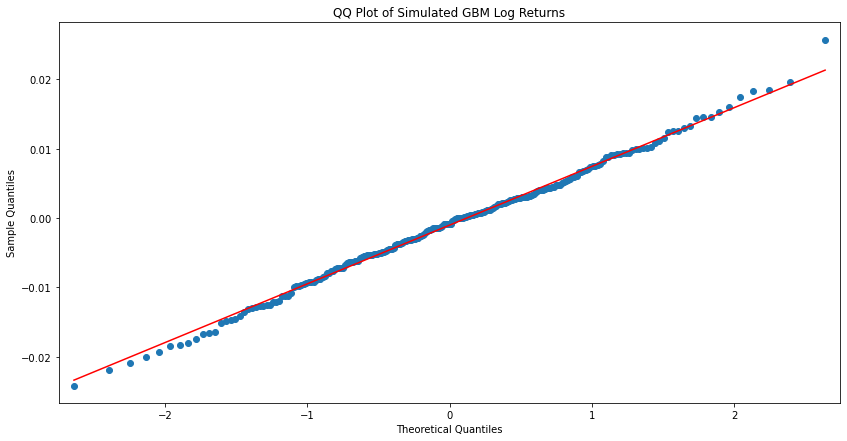

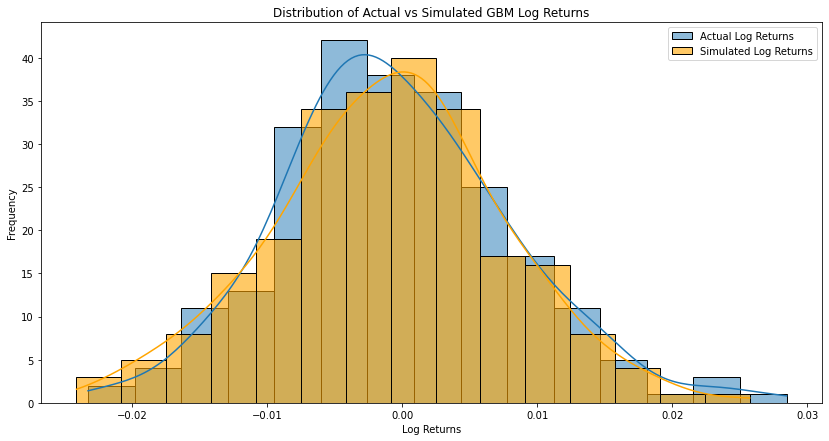

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

# 假设你的数据保存在一个名为hs_300的DataFrame中
# 例如：hs_300 = pd.read_csv('hs_300.csv')

# 选择时间范围
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
hs_300['Date'] = pd.to_datetime(hs_300['交易日期_TrdDt'])

# 筛选时间范围内的数据
period = hs_300[(hs_300['Date'] >= start_date) & (hs_300['Date'] <= end_date)]
index_data = period['收盘价_ClPr'].values
dates = period['Date']

# 计算对数收益率
log_returns = np.diff(np.log(index_data))

# 定义GBM模型的对数似然函数
def gbm_log_likelihood(params, data, dt):
    mu, sigma = params

    n = len(data)
    log_likelihood = 0

    for i in range(1, n):
        log_x_prev = np.log(data[i-1])
        log_x_curr = np.log(data[i])

        # 根据GBM模型计算对数收益率
        mean = (mu - 0.5 * sigma**2) * dt
        variance = (sigma * np.sqrt(dt))**2

        # 对数似然函数的贡献
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - ((log_x_curr - log_x_prev - mean) ** 2) / (2 * variance)

    return -log_likelihood  # 负对数似然函数用于最小化

# 时间步长（每日数据）
dt = 1 / period.shape[0] # 假设一年有252个交易日

# 初始参数猜测
initial_guess = [0.1, 0.2]

# 执行MLE
result = minimize(gbm_log_likelihood, initial_guess, args=(index_data, dt), method='L-BFGS-B', bounds=[(None, None), (0, None)])

mu_est, sigma_est = result.x
print(f"估计的参数: mu = {mu_est}, sigma = {sigma_est}")

# 仿真GBM模型生成的价格序列
simulated_prices = [index_data[0]]
for i in range(1, len(index_data)):
    log_x_prev = np.log(simulated_prices[-1])
    simulated_log_return = (mu_est - 0.5 * sigma_est**2) * dt + sigma_est * np.sqrt(dt) * np.random.normal()
    simulated_price = np.exp(log_x_prev + simulated_log_return)
    simulated_prices.append(simulated_price)

# 绘制实际价格与仿真价格
plt.figure(figsize=(14, 7))
plt.plot(dates, index_data, label='Actual Prices')
plt.plot(dates, simulated_prices, label='Simulated GBM Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Actual vs Simulated GBM Prices')
plt.legend()
plt.show()

# 绘制实际对数收益率与仿真对数收益率的比较
simulated_log_returns = np.diff(np.log(simulated_prices))
plt.figure(figsize=(14, 7))
plt.plot(dates[1:], log_returns, label='Actual Log Returns')
plt.plot(dates[1:], simulated_log_returns, label='Simulated Log Returns', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Actual vs Simulated GBM Log Returns')
plt.legend()
plt.show()

# 绘制对数收益率的QQ图
plt.figure(figsize=(14, 7))
qqplot(log_returns, line='s', ax=plt.gca())
plt.title('QQ Plot of Actual Log Returns')
plt.show()

plt.figure(figsize=(14, 7))
qqplot(simulated_log_returns, line='s', ax=plt.gca())
plt.title('QQ Plot of Simulated GBM Log Returns')
plt.show()

# 绘制对数收益率的分布图
plt.figure(figsize=(14, 7))
sns.histplot(log_returns, kde=True, label='Actual Log Returns')
sns.histplot(simulated_log_returns, kde=True, color='orange', label='Simulated Log Returns', alpha=0.6)
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Simulated GBM Log Returns')
plt.legend()
plt.show()


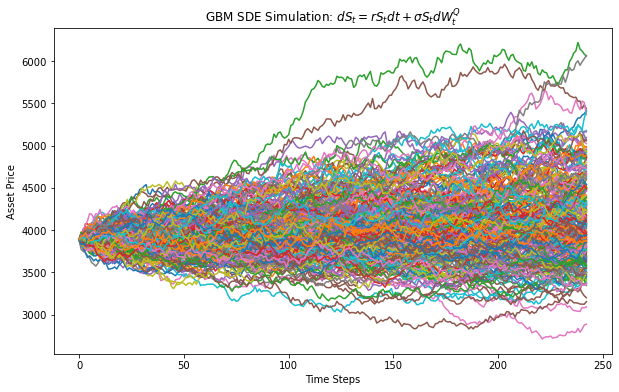

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, r, sigma, T, dt, num_paths):
    """
    使用Euler-Maruyama方法模拟dS_t = r S_t dt + sigma dW_t的过程

    参数:
    S0 : float : 初始资产价格
    r : float : 无风险利率
    sigma : float : 波动率
    T : float : 模拟的总时间（以年为单位）
    dt : float : 时间步长
    num_paths : int : 模拟路径数

    返回:
    np.ndarray : 模拟的资产价格路径
    """
    num_steps = int(T / dt)  # Number of time steps
    sqrt_dt = np.sqrt(dt)

    paths = np.zeros((num_steps + 1,num_paths))
    paths[0] = S0  # Initial value

    for t in range(1, num_steps + 1):
        log_x_prev = np.log(paths[t - 1])
        dW = np.random.normal(0, np.sqrt(dt), num_paths)
        simulated_log_return = (r - 0.5 * sigma**2) * dt + sigma * dW
        paths[t] = np.exp(log_x_prev + simulated_log_return)

    final_prices = paths[-1]
    return paths, final_prices

# 参数设置
S0 = index_data[0]  # 初始资产价格
r = 0.05  # 无风险利率
sigma = sigma_est  # 波动率
T = 1.0  # 总时间（以年为单位）
num_paths = period.shape[0] # 模拟路径数

# 模拟资产价格路径
paths, final_prices = simulate_gbm(S0, r, sigma, T, dt, num_paths)

# 绘制模拟路径
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(paths[:, i], lw=1.5)
plt.title('GBM SDE Simulation: $dS_t = r S_t dt + \sigma S_t dW^Q_t$')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

In [ ]:
def option_price_mc(S0, K, r, sigma, T, dt, num_paths,sde_type='ou',option_type='call'):
    """
    使用蒙特卡罗模拟计算欧式期权价格

    参数:
    S0 : float : 初始资产价格
    K : float : 期权行权价格
    r : float : 无风险利率
    sigma : float : 波动率
    T : float : 到期时间（以年为单位）
    dt : float : 时间步长
    num_paths : int : 模拟路径数
    option_type : str : 'call' 表示看涨期权，'put' 表示看跌期权

    返回:
    float : 期权价格
    """
       # 计算每条路径的期权支付
    if sde_type == 'ou':
        paths, final_prices = simulate_ou(S0, r, sigma, T, dt, num_paths)
    elif sde_type == 'gbm':
        paths, final_prices = simulate_gbm(S0, r, sigma, T, dt, num_paths)
    else:
        raise ValueError("sde_type必须是'ou'或'gbm'")

    # 计算每条路径的期权支付
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)
    else:
        raise ValueError("option_type必须是'call'或'put'")

    # 计算期权价格
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# 参数设置
S = 100  # 当前标的价格
K = 100  # 期权行权价格
T = 1.0  # 到期时间（以年为单位）
r = 0.05  # 无风险利率
sigma = 0.2  # 波动率

# 计算欧式看涨期权价格
call_price = option_price_mc(S, K, r, sigma, T, dt, num_paths=1000,sde_type='gbm',option_type='call')
print(f"欧式看涨期权价格: {call_price}")

# 计算欧式看跌期权价格
put_price = option_price_mc(S, K, r, sigma, T, dt, num_paths=1000,sde_type='gbm',option_type='put')
print(f"欧式看跌期权价格: {put_price}")

欧式看涨期权价格: 9.98697494909367
欧式看跌期权价格: 5.419276062535125


In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    计算欧式期权价格的Black-Scholes公式

    参数:
    S : float : 当前股票价格
    K : float : 期权行权价格
    T : float : 期权到期时间（以年为单位）
    r : float : 无风险利率
    sigma : float : 标的资产价格的波动率
    option_type : str : 'call' 表示看涨期权，'put' 表示看跌期权

    返回:
    float : 期权价格
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type必须是'call'或'put'")

    return price

# 参数设置
S = 100  # 当前标的价格
K = 100  # 期权行权价格
T = 1.0  # 到期时间（以年为单位）
r = 0.05  # 无风险利率
sigma = 0.2  # 波动率

# 计算欧式看涨期权价格
call_price = black_scholes(S, K, T, r, sigma, option_type='call')
print(f"欧式看涨期权价格: {call_price}")

# 计算欧式看跌期权价格
put_price = black_scholes(S, K, T, r, sigma, option_type='put')
print(f"欧式看跌期权价格: {put_price}")


欧式看涨期权价格: 10.450583572185565
欧式看跌期权价格: 5.573526022256971


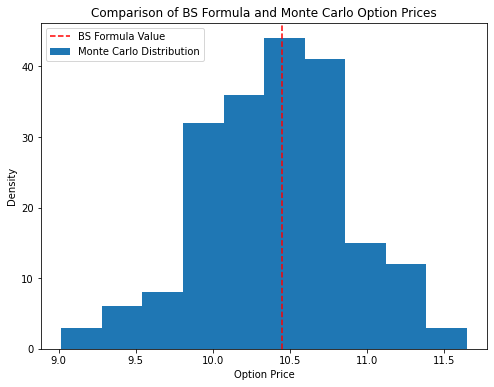

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你有以下数据
mc_samples = [option_price_mc(S, K, r, sigma, T, dt, num_paths=1000,sde_type='gbm',option_type='call')+0*i for i in range(200)]
bs_value = black_scholes(S, K, T, r, sigma, option_type='call')

# 计算Monte Carlo样本的分布
mc_mean = np.mean(mc_samples)
mc_std = np.std(mc_samples)

# 画分布图
plt.figure(figsize=(8, 6))
x = np.linspace(mc_mean - 3*mc_std, mc_mean + 3*mc_std, 100)
plt.hist(mc_samples, label='Monte Carlo Distribution')

# 添加BS公式计算的确定值作为竖线
plt.axvline(x=bs_value, color='r', linestyle='--', label='BS Formula Value')

plt.xlabel('Option Price')
plt.ylabel('Density')
plt.title('Comparison of BS Formula and Monte Carlo Option Prices')
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np

# 假设所有CSV文件都在一个名为option_data_files的文件夹中
folder_path = 'option_data_files'

# 获取所有CSV文件的文件名
file_names = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 获取所有交易日日期
# 假设你已经有一个包含所有交易日期的列表或DataFrame
# 确保交易日期列是datetime类型
hs_300['交易日期_TrdDt'] = pd.to_datetime(hs_300['交易日期_TrdDt'])

# 提取所有交易日期
trading_days = hs_300['交易日期_TrdDt'].sort_values().unique()

# 计算行权日期（第三个星期五）的辅助函数
def get_third_friday(year, month):
    first_day_of_month = pd.Timestamp(year=year, month=month, day=1)
    third_friday = first_day_of_month + pd.offsets.Week(weekday=4, n=2)
    return third_friday

# 计算当前日期到行权日期的交易日数的辅助函数
def calculate_trading_days_between(current_date, expiry_date, trading_days):
    return len(trading_days[(trading_days >= current_date) & (trading_days <= expiry_date)])

# 读取和处理每个CSV文件
all_data = []

for file_name in file_names:
    # 读取CSV文件
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path,encoding='gbk')

    # 添加日期列
    file_date_str = file_name.split('_')[0]
    file_date = pd.to_datetime(file_date_str, format='%Y%m%d')
    data['Date'] = file_date

    # 只保留合约开头是IO的期权
    data = data[data['合约代码'].str.startswith('IO')]

    # 解析合约名称，计算行权日期和距离到期日期的交易日天数
    def parse_contract_and_calculate(contract):
        year = int('20' + contract[2:4])
        month = int(contract[4:6])
        strike_price = int(contract.split('-')[-1])

        expiry_date = get_third_friday(year, month)
        trading_days_between = calculate_trading_days_between(file_date, expiry_date, trading_days)

        return pd.Series([expiry_date, trading_days_between, strike_price])

    data[['ExpiryDate', 'TradingDaysToExpiry', 'StrikePrice']] = data['合约代码'].apply(parse_contract_and_calculate)

    # 添加处理后的数据到all_data列表
    all_data.append(data)

# 合并所有数据到一个DataFrame
merged_data = pd.concat(all_data, ignore_index=True)

merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# 解析合约名称，添加一列表示是 call 还是 put 期权
merged_data['OptionType'] = merged_data['合约代码'].apply(lambda x: 'call' if 'C' in x else 'put')

# 保存合并后的数据到一个新的CSV文件
merged_data.to_csv('merged_option_data.csv', index=False)

print('数据处理完成并已保存到merged_option_data.csv')


数据处理完成并已保存到merged_option_data.csv


In [ ]:
merged_data

,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,今收盘,今结算,前结算,涨跌1,涨跌2,Delta,Date,ExpiryDate,TradingDaysToExpiry,StrikePrice,OptionType
0,IO2301-C-3150,NaN,NaN,NaN,0,0.000,65.0,0.0,717.2,750.0,735.4,-18.2,14.6,0.9950,2023-01-03,2023-01-13,9,3150,call
1,IO2301-C-3200,NaN,NaN,NaN,0,0.000,31.0,0.0,673.4,700.0,685.4,-12.0,14.6,0.9950,2023-01-03,2023-01-13,9,3200,call
2,IO2301-C-3250,NaN,NaN,NaN,0,0.000,44.0,0.0,636.0,650.2,635.6,0.4,14.6,0.9950,2023-01-03,2023-01-13,9,3250,call
3,IO2301-C-3300,NaN,NaN,NaN,0,0.000,55.0,0.0,594.2,600.2,585.8,8.4,14.4,0.9940,2023-01-03,2023-01-13,9,3300,call
4,IO2301-C-3350,NaN,NaN,NaN,0,0.000,46.0,0.0,542.0,550.4,536.0,6.0,14.4,0.9930,2023-01-03,2023-01-13,9,3350,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33355,IO2406-P-4000,167.2,180.4,162.2,84,144.502,78.0,43.0,180.4,180.4,182.0,-1.6,-1.6,-0.4080,2023-07-31,2024-06-14,104,4000,put
33356,IO2406-P-4100,216.2,229.2,216.2,3,6.746,65.0,2.0,229.2,231.0,233.0,-3.8,-2.0,-0.4780,2023-07-31,2024-06-14,104,4100,put
33357,IO2406-P-4200,267.6,280.2,267.6,18,49.662,105.0,18.0,280.2,286.0,289.6,-9.4,-3.6,-0.5470,2023-07-31,2024-06-14,104,4200,put
33358,IO2406-P-4300,327.2,340.4,326.4,43,142.798,90.0,26.0,340.4,347.8,353.2,-12.8,-5.4,-0.6130,2023-07-31,2024-06-14,104,4300,put


In [ ]:
# 从hs_300数据集中提取相应区间内的标的资产数据
def get_past_data(date, months_offset=1):
    past_data = hs_300[(hs_300['交易日期_TrdDt'] <= date) &
                       (hs_300['交易日期_TrdDt'] >= date - pd.DateOffset(months=months_offset))]
    return past_data['收盘价_ClPr'].values

# 处理合并后的期权数据集
for idx, row in merged_data.iterrows():
    date = row['Date']
    past_prices = get_past_data(date, months_offset=1)  # 获取前一个月的标的资产数据

    if len(past_prices) > 1:
        # 估计OU过程的sigma
        initial_guess_ou = [0.1, np.mean(past_prices), np.std(past_prices)]
        result_ou = minimize(ou_log_likelihood, initial_guess_ou, args=(past_prices, dt), method='L-BFGS-B', bounds=[(0, None), (None, None), (0, None)])
        ou_sigma = result_ou.x[2]

        # 估计GBM过程的sigma
        initial_guess_gbm = [np.mean(past_prices), np.std(np.diff(np.log(past_prices))) * np.sqrt(len(past_prices))]
        result_gbm = minimize(gbm_log_likelihood, initial_guess_gbm, args=(past_prices, dt), method='L-BFGS-B', bounds=[(None, None), (0, None)])
        gbm_sigma = result_gbm.x[1]
    else:
        ou_sigma = np.nan
        gbm_sigma = np.nan

    merged_data.at[idx, 'OUSigma'] = ou_sigma
    merged_data.at[idx, 'GBMSigma'] = gbm_sigma

    # 获取当天的标的资产价格
    current_price = hs_300[hs_300['交易日期_TrdDt'] == date]['收盘价_ClPr'].values[0]
    merged_data.at[idx, 'St'] = current_price

    # 计算理论期权定价
    T = row['TradingDaysToExpiry']*dt  # Assuming 252 trading days in a year
    K = row['StrikePrice']
    r = 0.05  # Assuming a risk-free rate of 5%
    option_type = row['OptionType']

    if not np.isnan(ou_sigma):
        call_price_ou=option_price_mc(current_price, K, r,ou_sigma, T, dt,num_paths=1000,sde_type='ou',option_type=option_type)
    else:
        call_price_ou = np.nan

    if not np.isnan(gbm_sigma):
        call_price_gbm = black_scholes(current_price, K, T, r,gbm_sigma, option_type=option_type)
    else:
        call_price_gbm = np.nan

    merged_data.at[idx, 'Price_OU'] = call_price_ou
    merged_data.at[idx, 'Price_GBM'] = call_price_gbm

# 保存处理后的数据到一个新的CSV文件
#merged_data.to_csv('processed_option_data.csv', index=False)

print('数据处理完成并已保存到 processed_option_data.csv')

C:\Users\dell\AppData\Local\Temp/ipykernel_20440/1963031822.py:40: RuntimeWarning: divide by zero encountered in log
  log_likelihood += -0.5 * np.log(2 * np.pi * variance) - ((log_x_curr - log_x_prev - mean) ** 2) / (2 * variance)
C:\Users\dell\AppData\Local\Temp/ipykernel_20440/1963031822.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  log_likelihood += -0.5 * np.log(2 * np.pi * variance) - ((log_x_curr - log_x_prev - mean) ** 2) / (2 * variance)
C:\Users\dell\AppData\Local\Temp/ipykernel_20440/1963031822.py:40: RuntimeWarning: invalid value encountered in double_scalars
  log_likelihood += -0.5 * np.log(2 * np.pi * variance) - ((log_x_curr - log_x_prev - mean) ** 2) / (2 * variance)
C:\Users\dell\AppData\Local\Temp/ipykernel_20440/2118125737.py:27: RuntimeWarning: invalid value encountered in double_scalars
  variance = (sigma ** 2) * (1 - np.exp(-2 * theta * dt)) / (2 * theta)
C:\Users\dell\AppData\Local\Temp/ipykernel_20440/245792445.py:19: RuntimeWarning: di

数据处理完成并已保存到 processed_option_data.csv


In [ ]:
merged_data = pd.read_csv('processed_option_data.csv')
merged_data

E:\python\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,合约代码,今开盘,最高价,最低价,成交量,成交金额,持仓量,持仓变化,今收盘,今结算,...,Date,ExpiryDate,TradingDaysToExpiry,StrikePrice,OptionType,OUSigma,GBMSigma,St,Price_OU,Price_GBM
0,IO2301-C-3150,NaN,NaN,NaN,0,0.000,65.0,0.0,717.2,750.0,...,2023-01-03,2023-01-13,9,3150,call,442.627849,0.639775,3887.90,747.854906,751.236502
1,IO2301-C-3200,NaN,NaN,NaN,0,0.000,31.0,0.0,673.4,700.0,...,2023-01-03,2023-01-13,9,3200,call,442.627849,0.639775,3887.90,690.272332,704.096697
2,IO2301-C-3250,NaN,NaN,NaN,0,0.000,44.0,0.0,636.0,650.2,...,2023-01-03,2023-01-13,9,3250,call,442.627849,0.639775,3887.90,645.025049,657.738049
3,IO2301-C-3300,NaN,NaN,NaN,0,0.000,55.0,0.0,594.2,600.2,...,2023-01-03,2023-01-13,9,3300,call,442.627849,0.639775,3887.90,591.805218,612.304029
4,IO2301-C-3350,NaN,NaN,NaN,0,0.000,46.0,0.0,542.0,550.4,...,2023-01-03,2023-01-13,9,3350,call,442.627849,0.639775,3887.90,543.285299,567.945000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33355,IO2406-P-4000,167.2,180.4,162.2,84,144.502,78.0,43.0,180.4,180.4,...,2023-07-31,2024-06-14,104,4000,put,55.732027,0.761854,4014.63,0.053646,732.976309
33356,IO2406-P-4100,216.2,229.2,216.2,3,6.746,65.0,2.0,229.2,231.0,...,2023-07-31,2024-06-14,104,4100,put,55.732027,0.761854,4014.63,13.563754,790.594151
33357,IO2406-P-4200,267.6,280.2,267.6,18,49.662,105.0,18.0,280.2,286.0,...,2023-07-31,2024-06-14,104,4200,put,55.732027,0.761854,4014.63,97.756503,850.060679
33358,IO2406-P-4300,327.2,340.4,326.4,43,142.798,90.0,26.0,340.4,347.8,...,2023-07-31,2024-06-14,104,4300,put,55.732027,0.761854,4014.63,195.099706,911.308299


In [ ]:
np.quantile(merged_data['成交量'],0.4)

13.0

In [ ]:
merged_data = merged_data[merged_data['成交量']>=20]

In [ ]:
merged_data[['合约代码','今收盘','TradingDaysToExpiry',"St",'StrikePrice','Price_OU','Price_GBM']]

,合约代码,今收盘,TradingDaysToExpiry,St,StrikePrice,Price_OU,Price_GBM
8,IO2301-C-3550,356.6,9,3887.90,3550,343.419763,404.288457
9,IO2301-C-3600,305.6,9,3887.90,3600,292.076112,367.522605
10,IO2301-C-3650,258.4,9,3887.90,3650,244.303710,332.652705
11,IO2301-C-3700,203.8,9,3887.90,3700,194.162523,299.764843
12,IO2301-C-3750,158.4,9,3887.90,3750,146.319439,268.922624
...,...,...,...,...,...,...,...
33352,IO2406-P-3700,80.2,104,4014.63,3700,0.000000,571.883273
33353,IO2406-P-3800,106.0,104,4014.63,3800,0.000000,623.555049
33354,IO2406-P-3900,136.2,104,4014.63,3900,0.000000,677.274443
33355,IO2406-P-4000,180.4,104,4014.63,4000,0.053646,732.976309


In [ ]:
merged_data.columns

Index(['合约代码', '今开盘', '最高价', '最低价', '成交量', '成交金额', '持仓量', '持仓变化', '今收盘', '今结算',
       '前结算', '涨跌1', '涨跌2', 'Delta', 'Date', 'ExpiryDate',
       'TradingDaysToExpiry', 'StrikePrice', 'OptionType', 'OUSigma',
       'GBMSigma', 'St', 'Price_OU', 'Price_GBM'],
      dtype='object')

In [ ]:
merged_data = merged_data[merged_data['GBMSigma']<0.3]

In [ ]:
np.percentile(merged_data['GBMSigma'],20)

0.1213332903158902

In [ ]:
np.percentile(merged_data['Price_GBM'],50)

26.742409169954385

In [ ]:
merged_data[['合约代码','今收盘','TradingDaysToExpiry',"St",'StrikePrice','Price_OU','Price_GBM']]

,合约代码,今收盘,TradingDaysToExpiry,St,StrikePrice,Price_OU,Price_GBM
9833,IO2303-C-3800,336.0,6,4130.55,3800,338.231277,335.261451
9834,IO2303-C-3850,286.0,6,4130.55,3850,289.266038,285.350293
9835,IO2303-C-3900,238.0,6,4130.55,3900,237.564926,235.573042
9836,IO2303-C-3950,187.4,6,4130.55,3950,191.174578,186.354066
9837,IO2303-C-4000,145.0,6,4130.55,4000,143.213016,138.863280
...,...,...,...,...,...,...,...
28793,IO2403-P-3800,149.4,125,3842.45,3800,93.000592,85.823896
28798,IO2403-P-4300,457.6,125,3842.45,4300,381.425945,386.757476
28805,IO2406-C-3700,345.4,125,3842.45,3700,290.689912,291.552431
28813,IO2406-P-3400,50.0,125,3842.45,3400,17.576938,9.236477


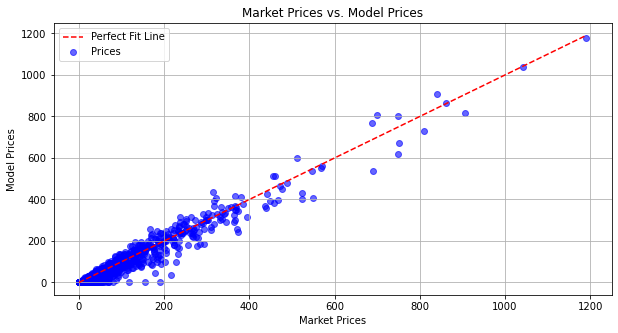

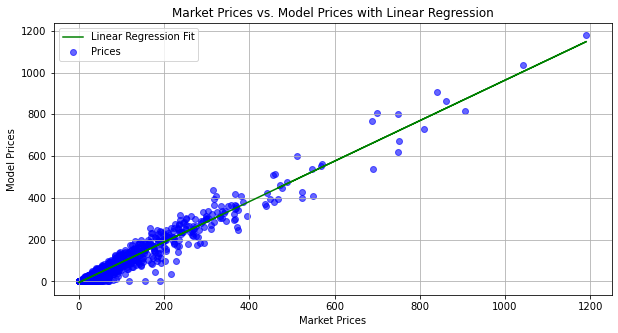

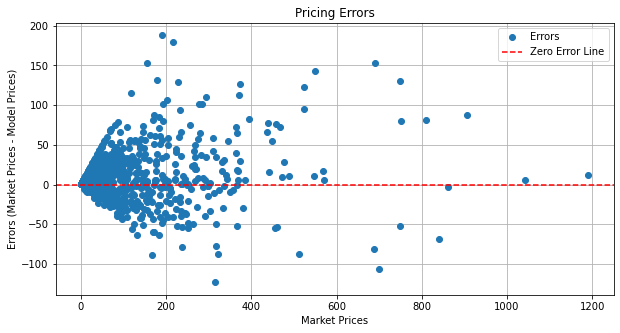

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 假设有市场价和模型计算的期权价格数据
market_prices = np.array(merged_data['今收盘'][0:10000]) # 市场价
model_prices = np.array(merged_data['Price_OU'][0:10000])  # 模型价

# 1. 绘制市场价与模型价的散点图
plt.figure(figsize=(10, 5))
plt.scatter(market_prices, model_prices, color='blue', label='Prices', alpha=0.6)
plt.plot([min(market_prices), max(market_prices)], [min(market_prices), max(market_prices)], color='red', linestyle='--', label='Perfect Fit Line')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Model Prices')
plt.title('Market Prices vs. Model Prices')
plt.legend()
plt.grid(True)
plt.show()

# 2. 绘制市场价与模型价的线性回归图
# 创建线性回归模型
reg = LinearRegression().fit(market_prices.reshape(-1, 1), model_prices)
model_prices_pred = reg.predict(market_prices.reshape(-1, 1))

# 绘制线性回归图
plt.figure(figsize=(10, 5))
plt.scatter(market_prices, model_prices, color='blue', label='Prices', alpha=0.6)
plt.plot(market_prices, model_prices_pred, color='green', label='Linear Regression Fit')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Model Prices')
plt.title('Market Prices vs. Model Prices with Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# 3. 绘制误差图（市场价 - 模型价）
errors = market_prices - model_prices
plt.figure(figsize=(10, 5))
plt.plot(market_prices, errors, 'o', label='Errors')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Errors (Market Prices - Model Prices)')
plt.title('Pricing Errors')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid(True)
plt.show()


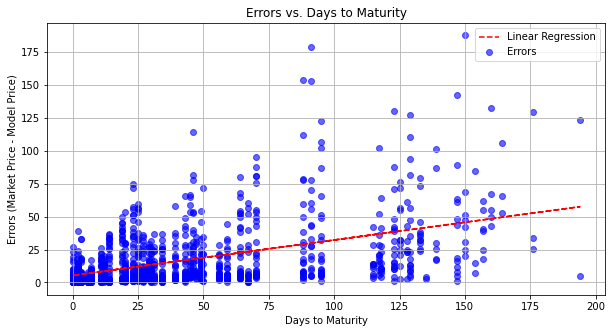

Text(0.5, 1.0, 'Errors vs. Strike Price')

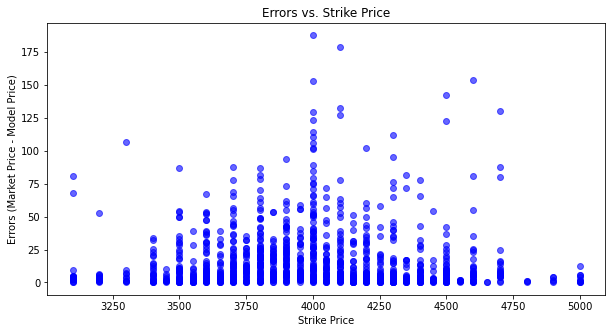

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 假设有市场价、模型计算的期权价格、距离到期交易日个数和行权价格数据
market_prices = np.array(merged_data['今收盘'][0:10000]) # 市场价
model_prices = np.array(merged_data['Price_OU'][0:10000])  # 模型价
days_to_maturity = np.array(merged_data['TradingDaysToExpiry'][0:10000])  # 距离到期日天数
strike_prices = np.array(merged_data['StrikePrice'][0:10000])  # 行权价格
moneyness = merged_data['St'][0:10000]/strike_prices

# 计算误差
errors = abs(market_prices - model_prices)

# 1. 误差与距离到期交易日个数的关系
plt.figure(figsize=(10, 5))
plt.scatter(days_to_maturity, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Days to Maturity')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Days to Maturity')

# 添加线性回归线
reg1 = LinearRegression().fit(days_to_maturity.reshape(-1, 1), errors)
errors_pred1 = reg1.predict(days_to_maturity.reshape(-1, 1))
plt.plot(days_to_maturity, errors_pred1, color='red', linestyle='--', label='Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# 2. 误差与行权价格的关系
plt.figure(figsize=(10, 5))
plt.scatter(strike_prices, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Strike Price')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Strike Price')


Text(0.5, 1.0, 'Errors vs. Moneyness')

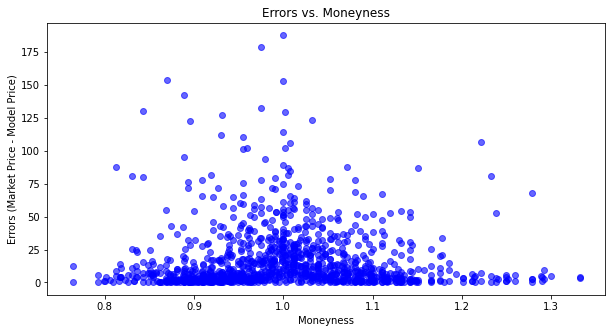

In [ ]:
# 2. 误差与行权价格的关系
plt.figure(figsize=(10, 5))
plt.scatter(moneyness, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Moneyness')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Moneyness')

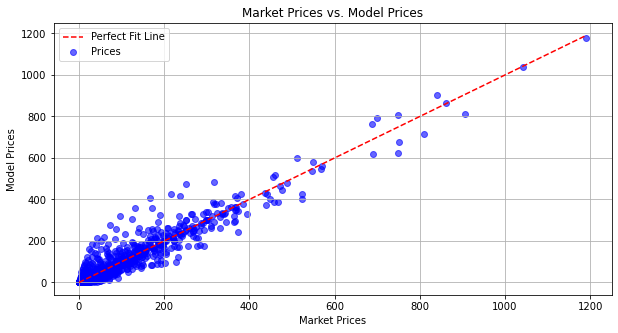

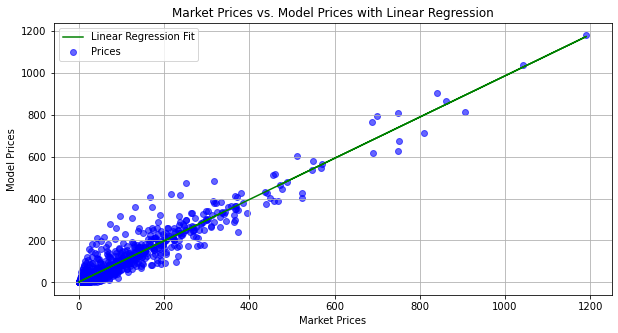

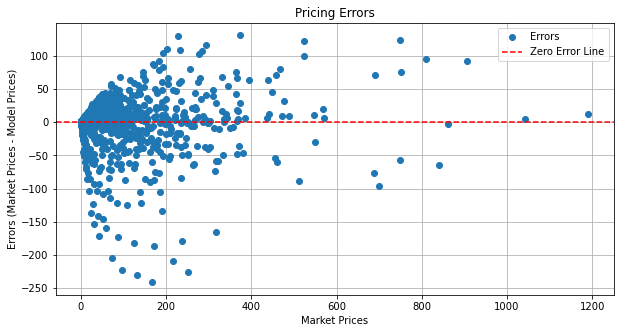

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 假设有市场价和模型计算的期权价格数据
market_prices = np.array(merged_data['今收盘'][0:10000]) # 市场价
model_prices = np.array(merged_data['Price_GBM'][0:10000])  # 模型价

# 1. 绘制市场价与模型价的散点图
plt.figure(figsize=(10, 5))
plt.scatter(market_prices, model_prices, color='blue', label='Prices', alpha=0.6)
plt.plot([min(market_prices), max(market_prices)], [min(market_prices), max(market_prices)], color='red', linestyle='--', label='Perfect Fit Line')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Model Prices')
plt.title('Market Prices vs. Model Prices')
plt.legend()
plt.grid(True)
plt.show()

# 2. 绘制市场价与模型价的线性回归图
# 创建线性回归模型
reg = LinearRegression().fit(market_prices.reshape(-1, 1), model_prices)
model_prices_pred = reg.predict(market_prices.reshape(-1, 1))

# 绘制线性回归图
plt.figure(figsize=(10, 5))
plt.scatter(market_prices, model_prices, color='blue', label='Prices', alpha=0.6)
plt.plot(market_prices, model_prices_pred, color='green', label='Linear Regression Fit')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Model Prices')
plt.title('Market Prices vs. Model Prices with Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# 3. 绘制误差图（市场价 - 模型价）
errors = market_prices - model_prices
plt.figure(figsize=(10, 5))
plt.plot(market_prices, errors, 'o', label='Errors')

# 设置图表标签和标题
plt.xlabel('Market Prices')
plt.ylabel('Errors (Market Prices - Model Prices)')
plt.title('Pricing Errors')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.legend()
plt.grid(True)
plt.show()

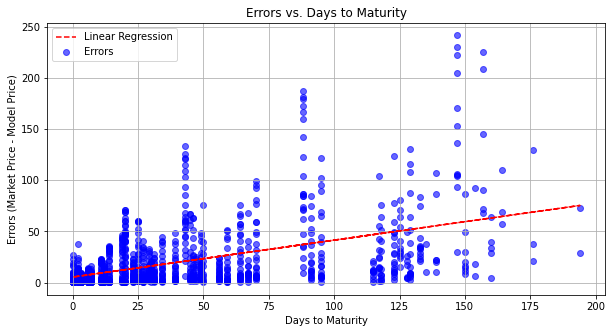

Text(0.5, 1.0, 'Errors vs. Strike Price')

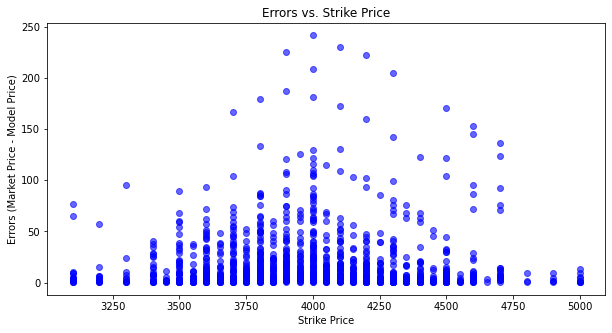

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 假设有市场价、模型计算的期权价格、距离到期交易日个数和行权价格数据
market_prices = np.array(merged_data['今收盘'][0:10000]) # 市场价
model_prices = np.array(merged_data['Price_GBM'][0:10000])  # 模型价
days_to_maturity = np.array(merged_data['TradingDaysToExpiry'][0:10000])  # 距离到期日天数
strike_prices = np.array(merged_data['StrikePrice'][0:10000])  # 行权价格
moneyness = merged_data['St'][0:10000]/strike_prices

# 计算误差
errors = abs(market_prices - model_prices)

# 1. 误差与距离到期交易日个数的关系
plt.figure(figsize=(10, 5))
plt.scatter(days_to_maturity, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Days to Maturity')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Days to Maturity')

# 添加线性回归线
reg1 = LinearRegression().fit(days_to_maturity.reshape(-1, 1), errors)
errors_pred1 = reg1.predict(days_to_maturity.reshape(-1, 1))
plt.plot(days_to_maturity, errors_pred1, color='red', linestyle='--', label='Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# 2. 误差与行权价格的关系
plt.figure(figsize=(10, 5))
plt.scatter(strike_prices, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Strike Price')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Strike Price')


Text(0.5, 1.0, 'Errors vs. Moneyness')

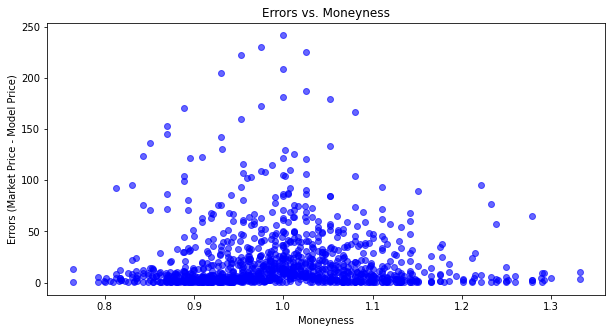

In [ ]:
# 2. 误差与行权价格的关系
plt.figure(figsize=(10, 5))
plt.scatter(moneyness, errors, color='blue', alpha=0.6, label='Errors')
plt.xlabel('Moneyness')
plt.ylabel('Errors (Market Price - Model Price)')
plt.title('Errors vs. Moneyness')

In [ ]:
#import libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

2024-05-31 06:51:43.840482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 06:51:43.840587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 06:51:43.965164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
class EuropeanOptionBS:

    def __init__(self, S, K, T, r, q, sigma,Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()

    def d1(self):
        d1 = (math.log(self.S / self.K) \
                   + (self.r - self.q + .5 * (self.sigma ** 2)) * self.T) \
                    / (self.sigma * self.T ** .5)
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * self.T ** .5
        return d2

    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) \
            - self.K * math.exp(-self.r *self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) \
            - self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return price

In [ ]:
#dataset
r = np.arange(.0, .1, .01) #interest rates
Strike = np.arange(50, 155, 5) #strike price
T = np.arange(0.1, 2.1, 0.1) #time to maturity
sigma = np.arange(0.1, 2.1, .1) #volatility

data = []
for r_ in r:
    for Strike_ in Strike:
        for T_ in T:
            for sigma_ in sigma:
                data.append([r_, Strike_, T_, sigma_, \
                             EuropeanOptionBS(100, Strike_, T_, r_, 0, sigma_, "Call").price])
data = np.asarray(data)

In [ ]:
#training and test datasets
X = data[:,:4] #params r, strike, T, sigma
y = data[:,4:5] #call price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
#ANN with four layers, 10 neurons each
#activation function: ReLU
ANN = Sequential()
ANN.add(Dense(10,input_dim = 4, activation = 'relu'))
ANN.add(Dense(10, activation = 'relu'))
ANN.add(Dense(10, activation = 'relu'))
ANN.add(Dense(10, activation = 'relu'))
ANN.add(Dense(1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Loss function = MSE, optimizer: Adam
ANN.compile(loss = 'mean_squared_error', optimizer='adam')
# fit the ANN on the training dataset
ANN.fit(X_train, y_train, epochs = 150)

Epoch 1/150
  91/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1302.1272

I0000 00:00:1717138491.729137     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717138491.745139     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 665.3971
Epoch 2/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 49.5346
Epoch 3/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 49.7347
Epoch 4/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 48.7225
Epoch 5/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 46.4823
Epoch 6/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 39.8222
Epoch 7/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30.3678
Epoch 8/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26.6140
Epoch 9/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 25.4967
Epoch 10/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 24.6509
Epoch 11/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 24.3844
Epoch 12/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 23.8894
Epoch 13/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 23.8774
Epoch 14/150
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 23.6154
Epoch 15/150

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


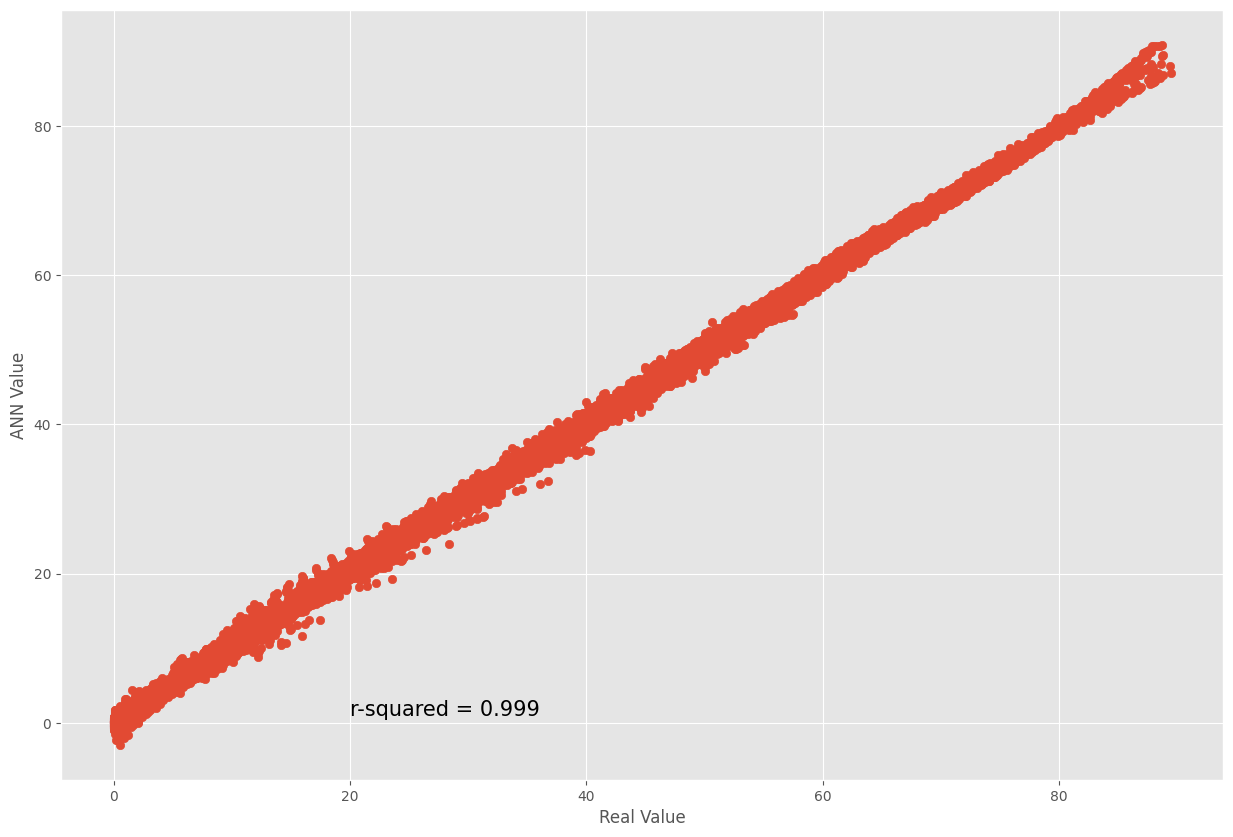

In [ ]:
#prediction
y_pred = ANN.predict(X_test)

#Comparison real values and predictions on test dataset
plt.figure(figsize = (15,10))
plt.scatter(y_test, y_pred)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (20, 1), size = 15)
plt.show();

In [ ]:
K = 120 #strike price
r = 0.05 #risk-free interest rate
sigma = .3 #implied volatiltiy
T = .5 #time to maturity
S = np.arange(50, 151, 1) #asset prices

PriceBS = [EuropeanOptionBS(S_, K, T, r, 0, sigma, "Call").price for S_ in S]
PriceANN = [S_ / 100 * \
            ANN.predict(np.array([[r, K / S_ * 100, T, sigma]]))[0][0] for S_ in S]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

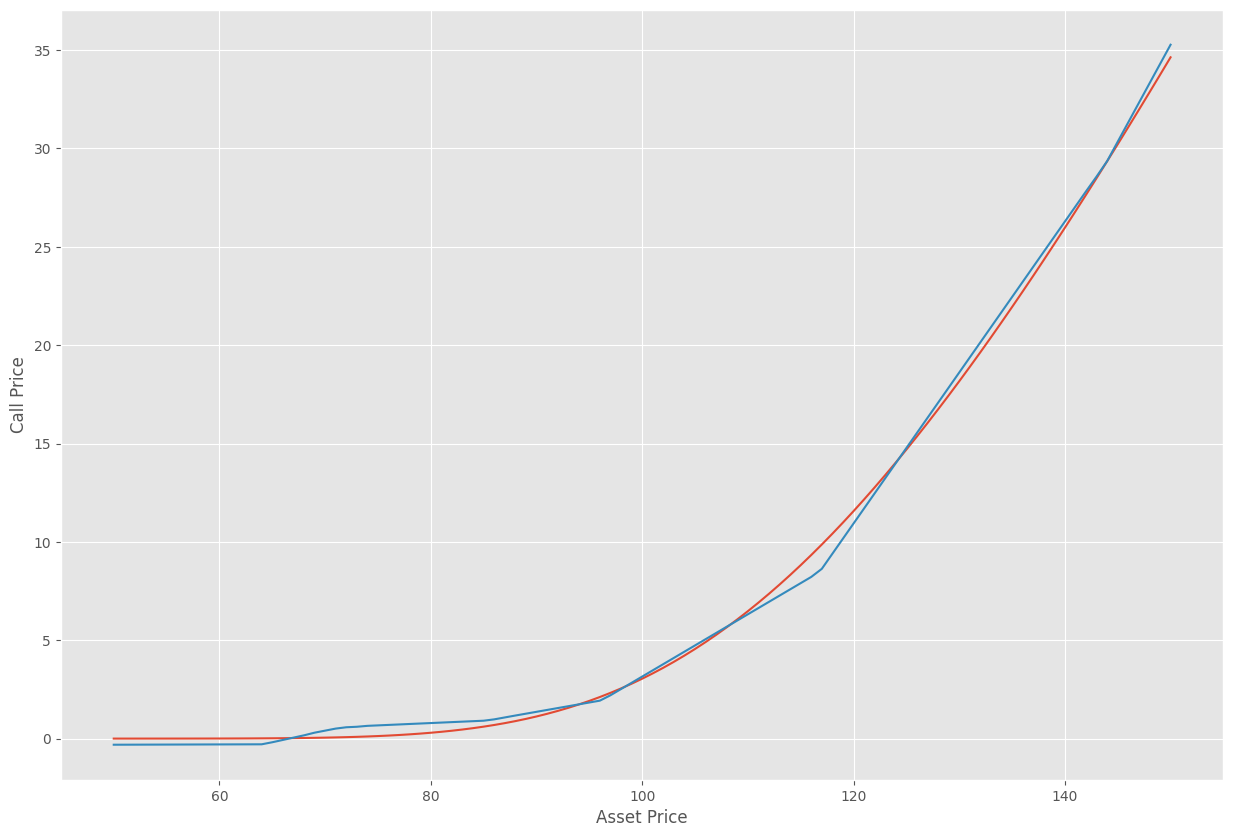

In [ ]:
#Comparison BS vs ANN prices
plt.figure(figsize = (15,10))
plt.plot(S, PriceBS, label = "Black-Scholes price")
plt.plot(S, PriceANN, label = "ANN price")
plt.xlabel("Asset Price")
plt.ylabel("Call Price")
plt.show();